<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_Autoencoder_Data_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0083 - val_loss: 0.0041
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4488e-04

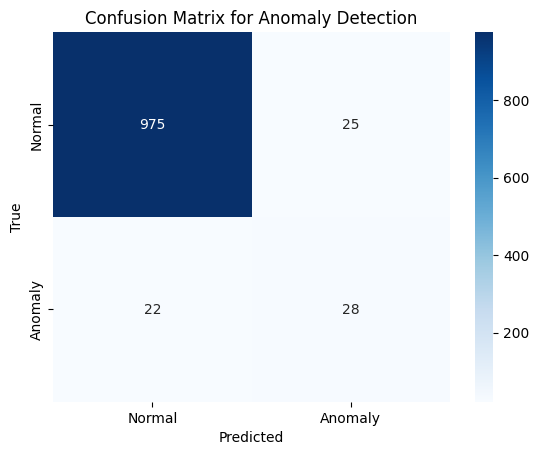

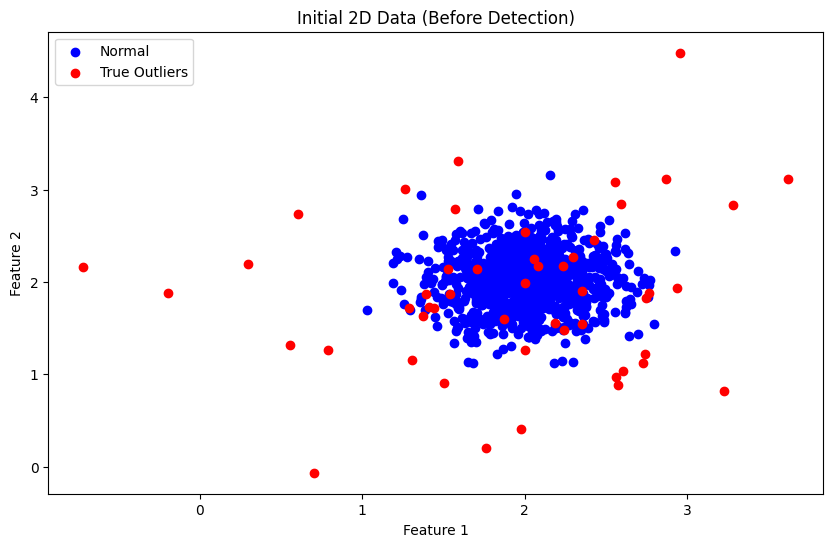

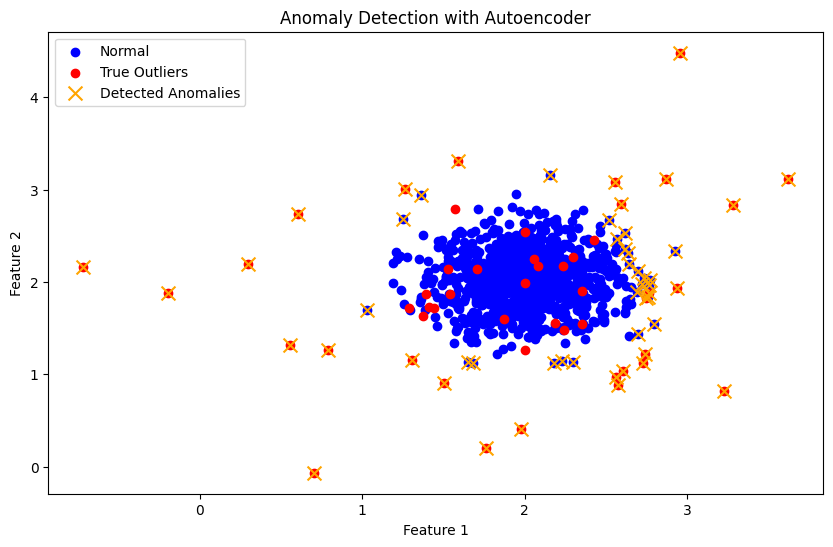

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Generate synthetic 2D data: mostly "normal" points plus a few outliers
def generate_2d_data(n_normal=2000, n_outliers=10):
    # a) Normal data: centered at (2,2), small spread (σ=0.3)
    normal_data = np.random.normal(loc=2, scale=0.3, size=(n_normal, 2))
    # b) Outliers: same center but larger spread (σ=0.9)
    outliers = np.random.normal(loc=2, scale=0.9, size=(n_outliers, 2))
    # Combine normal + outlier points into one array
    data = np.vstack([normal_data, outliers])
    # Create labels: 0 for normal, 1 for outlier
    labels = np.array([0] * n_normal + [1] * n_outliers)
    return data, labels

# 2. Normalize the data to [0,1] range using MinMaxScaler
scaler = MinMaxScaler()
data, labels = generate_2d_data(n_normal=1000, n_outliers=50)
data_scaled = scaler.fit_transform(data)

# 3. Prepare training and test sets:
x_train = data_scaled[labels == 0]
x_test = data_scaled

# 4. Build the autoencoder model
input_layer = layers.Input(shape=(2,))
x = layers.Dense(128, activation='relu')(input_layer)
x = layers.Dense(64, activation='relu')(x)
encoded = layers.Dense(32, activation='relu')(x)

x = layers.Dense(64, activation='relu')(encoded)
x = layers.Dense(128, activation='relu')(x)
decoded = layers.Dense(2, activation='sigmoid')(x)

autoencoder = models.Model(input_layer, decoded)

# 5. Compile the model
autoencoder.compile(optimizer='adamax', loss='mse')

# 6. Train the autoencoder
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)

# 7. Use the trained autoencoder to reconstruct all test points
decoded_imgs = autoencoder.predict(x_test)

# 8. Compute reconstruction error for each point
reconstruction_errors = np.mean(
    np.square(decoded_imgs - x_test),
    axis=1
)

# 9. Define an anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)

# 10. Classify each test point
y_pred = (reconstruction_errors > threshold).astype(int)

# 11. Evaluate with a confusion matrix
cm = confusion_matrix(labels, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal','Anomaly'],
    yticklabels=['Normal','Anomaly']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()

# 12. Visualize the raw data before detection
plt.figure(figsize=(10, 6))
plt.scatter(
    data[labels == 0, 0],
    data[labels == 0, 1],
    c='blue',
    label='Normal'
)
plt.scatter(
    data[labels == 1, 0],
    data[labels == 1, 1],
    c='red',
    label='True Outliers'
)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Initial 2D Data (Before Detection)')
plt.legend()
plt.show()

# 13. Visualize detection results
plt.figure(figsize=(10, 6))
plt.scatter(
    data[labels == 0, 0],
    data[labels == 0, 1],
    c='blue',
    label='Normal'
)
plt.scatter(
    data[labels == 1, 0],
    data[labels == 1, 1],
    c='red',
    label='True Outliers'
)
plt.scatter(
    data[y_pred == 1, 0],
    data[y_pred == 1, 1],
    c='orange',
    marker='x',
    s=100,
    label='Detected Anomalies'
)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Anomaly Detection with Autoencoder')
plt.legend()
plt.show()